In [1]:
import os
import pandas as pd
import keras
from keras import layers
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

In [2]:
csv_path_long = 'Total_long_Utterance_file.csv'
df_long = pd.read_csv(csv_path_long)
df_long.head()

,FileName,Label
0,common_voice_en_38487408.wav,English
1,common_voice_en_38487411.wav,English
2,common_voice_en_38487412.wav,English
3,common_voice_en_38487413.wav,English
4,common_voice_en_38487414.wav,English


In [3]:
shuffled_df_long = df_long.sample(frac=1).reset_index(drop=True)
shuffled_df_long

,FileName,Label
0,common_voice_fr_38166430.wav,French
1,common_voice_pt_38531642.wav,Portuguese
2,common_voice_en_38495846.wav,English
3,common_voice_de_38511816.wav,German
4,common_voice_en_38491136.wav,English
...,...,...
4994,common_voice_pt_38495099.wav,Portuguese
4995,common_voice_ta_37327450.wav,Tamil
4996,common_voice_pt_38899591.wav,Portuguese
4997,common_voice_en_38501272.wav,English


In [4]:
csv_path_short = 'Total_short_Utterance_file.csv'
df_short = pd.read_csv(csv_path_short)
df_short.head()

,FileName,Label
0,common_voice_en_38487409.wav,English
1,common_voice_en_38487410.wav,English
2,common_voice_en_38487420.wav,English
3,common_voice_en_38487556.wav,English
4,common_voice_en_38491060.wav,English


In [5]:
shuffled_df_short = df_short.sample(frac=1).reset_index(drop=True)
shuffled_df_short

,FileName,Label
0,common_voice_fr_38031821.wav,French
1,common_voice_de_38557699.wav,German
2,common_voice_de_38508628.wav,German
3,common_voice_ta_37324265.wav,Tamil
4,common_voice_fr_38031796.wav,French
...,...,...
2495,common_voice_ta_37311064.wav,Tamil
2496,common_voice_fr_38273552.wav,French
2497,common_voice_en_38510778.wav,English
2498,common_voice_de_38603965.wav,German


In [6]:
audio_dir_long = 'LongShortUtteranceData/'
audio_dir_short = 'LongShortUtteranceData/'

In [7]:
def load_and_preprocess_old(file_path):
    audio, _ = librosa.load(file_path, res_type='kaiser_fast', duration=3, sr=16000, offset=0)
    mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=13,win_length = 512,hop_length = 256,n_fft = 512)
    return mfccs

In [8]:
def load_and_preprocess(file_path, start_time, end_time, sr=16000):
    audio, sr = librosa.load(file_path, sr=sr, offset=start_time, duration=end_time - start_time)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13,win_length = 512,hop_length = 256,n_fft = 512)#win_length = 32,hop_length = 256,n_fft = 512)
    return mfccs.T

In [9]:
# Create a list to store MFCCs and labels
mfccs_list = []
labels = []

In [10]:
for index, row in shuffled_df_long.iterrows():
    file_path = os.path.join(audio_dir_long, row['FileName'])
    audio_duration = librosa.get_duration(filename=file_path)
    
    offset = 0
    while offset < audio_duration:
        end_time = min(offset + 3, audio_duration)  # Ensure end_time does not exceed audio duration
        mfccs = load_and_preprocess(file_path, offset, end_time)
        mfccs_list.append(mfccs)
        labels.append(row['Label'])
        offset += 3

'''
for index, row in shuffled_df_long.iterrows():
    file_path = os.path.join(audio_dir_long, row['FileName'])
    mfccs = load_and_preprocess_old(file_path)
    mfccs_list.append(mfccs.T)
    labels.append(row['Label'])'''

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16008\3133582249.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  audio_duration = librosa.get_duration(filename=file_path)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_16008\3133582249.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  audio_duration = librosa.get_duration(filename=file_path)
C:\Users\ASUS\anaconda3\envs\LocalGpu\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=192
  warnings.warn(


"\nfor index, row in shuffled_df_long.iterrows():\n    file_path = os.path.join(audio_dir_long, row['FileName'])\n    mfccs = load_and_preprocess_old(file_path)\n    mfccs_list.append(mfccs.T)\n    labels.append(row['Label'])"

In [11]:
print(len(mfccs_list))
print(len(labels))

12920
12920


In [12]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_mfccs_long = pad_sequences(mfccs_list, dtype='float32', padding='post', truncating='post')

print(padded_mfccs_long.shape)

(12920, 188, 13)


In [13]:
mfccs_array = np.array(padded_mfccs_long)

In [14]:
# Flatten MFCCs array to 2D
mfccs_flattened = mfccs_array.reshape(-1, mfccs_array.shape[-1])

In [15]:
# Scale the MFCCs data
scaler = StandardScaler()
mfccs_scaled = scaler.fit_transform(mfccs_flattened)

In [16]:
# data back to 3D
mfccs_scaled_3d = mfccs_scaled.reshape(mfccs_array.shape[0], mfccs_array.shape[1], mfccs_array.shape[2])

In [17]:
X = np.array(mfccs_scaled_3d)
y = np.array(labels)

In [18]:
le = LabelEncoder()
y_encoded_long = le.fit_transform(y)

In [19]:
print("Encoded Labels:")
for encoded_label, original_label in zip(range(len(le.classes_)), le.classes_):
    print(f"{encoded_label}: {original_label}")

Encoded Labels:
0: English
1: French
2: German
3: Portuguese
4: Tamil


In [20]:
# Split the data into 80% training and 20% remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y_encoded_long, test_size=0.2, random_state=42)

# Split the remaining data into 50% validation and 50% test
X_validation, X_test, y_validation, y_test= train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

In [22]:
np.save('lidbox_train_data/X_train.npy', X_train)
np.save('lidbox_train_data/y_train.npy', y_train)

# Save the validation data
np.save('lidbox_train_data/X_validation.npy', X_validation)
np.save('lidbox_train_data/y_validation.npy', y_validation)

# Save the test data
np.save('lidbox_train_data/X_test.npy', X_test)
np.save('lidbox_train_data/y_test.npy', y_test)

In [23]:
X_train_new = np.load('lidbox_train_data/X_train.npy')
y_train_new = np.load('lidbox_train_data/y_train.npy')

In [27]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    
    def call(self, inputs):
        # Forward pass of the student model
        return self.student(inputs)
    
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
    def predict_step(self, data):
        # Unpack the data
        x = data

        # Compute predictions
        return self.student(x, training=False)

In [28]:
teacher = keras.Sequential(
    [  
        layers.Conv1D(filters=500, kernel_size=5, strides=1, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=500, kernel_size=7, strides=2, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=500, kernel_size=1, strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=1000, kernel_size=1, strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
    
        layers.GlobalAveragePooling1D(),
        
        layers.Dense(1500, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(600, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(5, activation='softmax')

    ],
    name="teacher",
)


In [29]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 184, 500)          33000     
_________________________________________________________________
batch_normalization (BatchNo (None, 184, 500)          2000      
_________________________________________________________________
dropout (Dropout)            (None, 184, 500)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 89, 500)           1750500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 89, 500)           2000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 89, 500)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 500)           2505

In [30]:

# Create the student
student = keras.Sequential(
    [
        layers.Conv1D(filters=500, kernel_size=5, strides=1, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=500, kernel_size=7, strides=2, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=500, kernel_size=1, strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=1000, kernel_size=1, strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
    
        layers.GlobalAveragePooling1D(),
        
        layers.Dense(1000, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(400, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(5, activation='softmax')
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

In [31]:
student.summary()

Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 184, 500)          33000     
_________________________________________________________________
batch_normalization_4 (Batch (None, 184, 500)          2000      
_________________________________________________________________
dropout_6 (Dropout)          (None, 184, 500)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 89, 500)           1750500   
_________________________________________________________________
batch_normalization_5 (Batch (None, 89, 500)           2000      
_________________________________________________________________
dropout_7 (Dropout)          (None, 89, 500)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 89, 500)           2505

In [32]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adagrad


# Compile teacher model with RMSprop optimizer
teacher.compile(
    optimizer=RMSprop(learning_rate=0.001),  # Initial learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)



# Train and evaluate teacher on data with learning rate schedule
history = teacher.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_validation, y_validation)
)

# Evaluate the teacher model on test data
evaluation_result = teacher.evaluate(X_test, y_test)


Epoch 1/100


C:\Users\ASUS\anaconda3\envs\LocalGpu\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


323/323 [==============================] - 29s 32ms/step - loss: 1.0378 - sparse_categorical_accuracy: 0.6372 - val_loss: 0.7300 - val_sparse_categorical_accuracy: 0.7724
Epoch 2/100
323/323 [==============================] - 10s 31ms/step - loss: 0.7515 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.5658 - val_sparse_categorical_accuracy: 0.8297
Epoch 3/100
323/323 [==============================] - 10s 31ms/step - loss: 0.6824 - sparse_categorical_accuracy: 0.7723 - val_loss: 0.7370 - val_sparse_categorical_accuracy: 0.7848
Epoch 4/100
323/323 [==============================] - 10s 31ms/step - loss: 0.5717 - sparse_categorical_accuracy: 0.8048 - val_loss: 0.4921 - val_sparse_categorical_accuracy: 0.8444
Epoch 5/100
323/323 [==============================] - 10s 32ms/step - loss: 0.5080 - sparse_categorical_accuracy: 0.8219 - val_loss: 0.4486 - val_sparse_categorical_accuracy: 0.8491
Epoch 6/100
323/323 [==============================] - 10s 32ms/step - loss: 0.5081 - sparse_cate

In [33]:
# Print the evaluation result
print("Evaluation Loss: {:.4f}".format(evaluation_result[0]))
print("Evaluation Accuracy: {:.2f}%".format(evaluation_result[1] * 100))

Evaluation Loss: 0.9956
Evaluation Accuracy: 92.65%


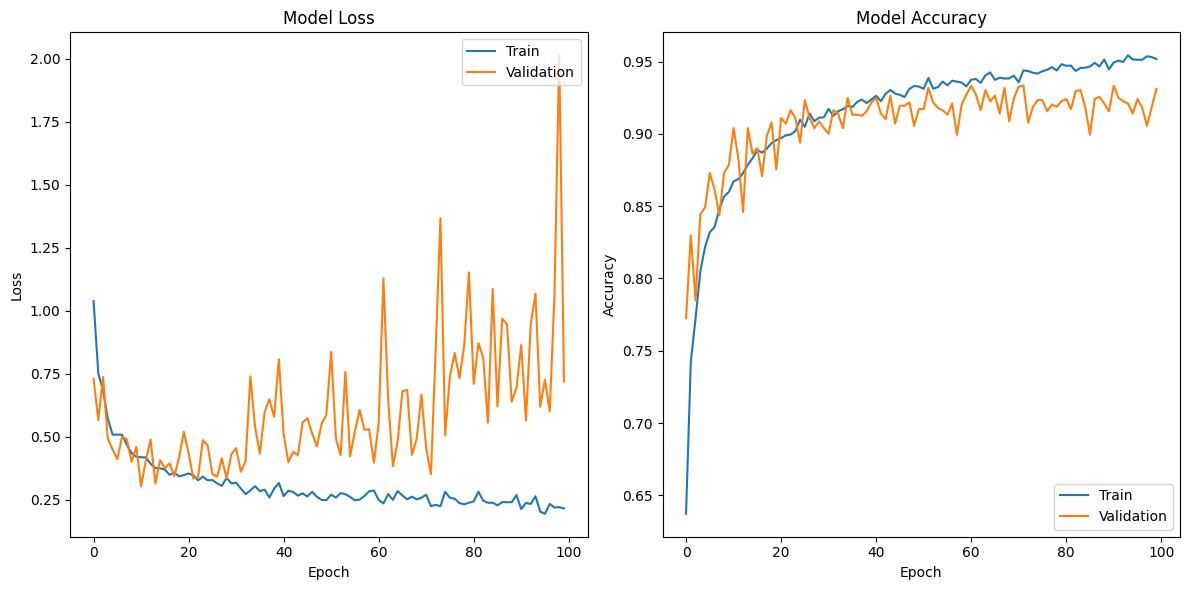

In [34]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

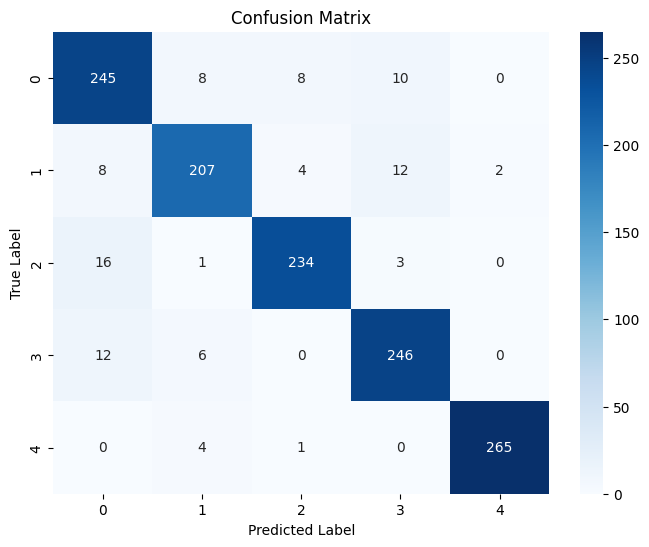

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       271
           1       0.92      0.89      0.90       233
           2       0.95      0.92      0.93       254
           3       0.91      0.93      0.92       264
           4       0.99      0.98      0.99       270

    accuracy                           0.93      1292
   macro avg       0.93      0.93      0.93      1292
weighted avg       0.93      0.93      0.93      1292



In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_teacher = np.argmax(teacher.predict(X_test), axis=1)

# True labels
y_true = y_test

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_teacher)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_teacher))

In [36]:
# Save the trained teacher model
#teacher.save('Lidbox_teacher_model.keras')

## Student Model Training

In [37]:
'''
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=RMSprop(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student and store the training history
history_distill = distiller.fit(X_train, y_train, epochs=60, batch_size = 64, validation_data=(X_validation, y_validation))

'''

'\ndistiller = Distiller(student=student, teacher=teacher)\ndistiller.compile(\n    optimizer=RMSprop(learning_rate=0.001),\n    metrics=[keras.metrics.SparseCategoricalAccuracy()],\n    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n    distillation_loss_fn=keras.losses.KLDivergence(),\n    alpha=0.1,\n    temperature=10,\n)\n\n# Distill teacher to student and store the training history\nhistory_distill = distiller.fit(X_train, y_train, epochs=60, batch_size = 64, validation_data=(X_validation, y_validation))\n\n'

In [38]:
# Compile the distiller model with SGD optimizer
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=SGD(learning_rate=0.04, momentum=0.9),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

# Distill teacher to student and store the training history
history_distill = distiller.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_validation, y_validation))

Epoch 1/30


C:\Users\ASUS\anaconda3\envs\LocalGpu\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


162/162 [==============================] - 15s 73ms/step - sparse_categorical_accuracy: 0.6485 - student_loss: 0.8989 - distillation_loss: 0.0466 - val_sparse_categorical_accuracy: 0.3065 - val_student_loss: 1.6932
Epoch 2/30
162/162 [==============================] - 12s 72ms/step - sparse_categorical_accuracy: 0.7925 - student_loss: 0.5839 - distillation_loss: 0.0283 - val_sparse_categorical_accuracy: 0.7237 - val_student_loss: 0.6017
Epoch 3/30
162/162 [==============================] - 12s 72ms/step - sparse_categorical_accuracy: 0.8268 - student_loss: 0.4868 - distillation_loss: 0.0229 - val_sparse_categorical_accuracy: 0.8529 - val_student_loss: 0.2107
Epoch 4/30
162/162 [==============================] - 12s 72ms/step - sparse_categorical_accuracy: 0.8513 - student_loss: 0.4126 - distillation_loss: 0.0192 - val_sparse_categorical_accuracy: 0.8854 - val_student_loss: 0.2191
Epoch 5/30
162/162 [==============================] - 12s 72ms/step - sparse_categorical_accuracy: 0.8656 -

In [39]:
evaluation_result = distiller.evaluate(X_test, y_test)

41/41 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.9241 - student_loss: 0.2585


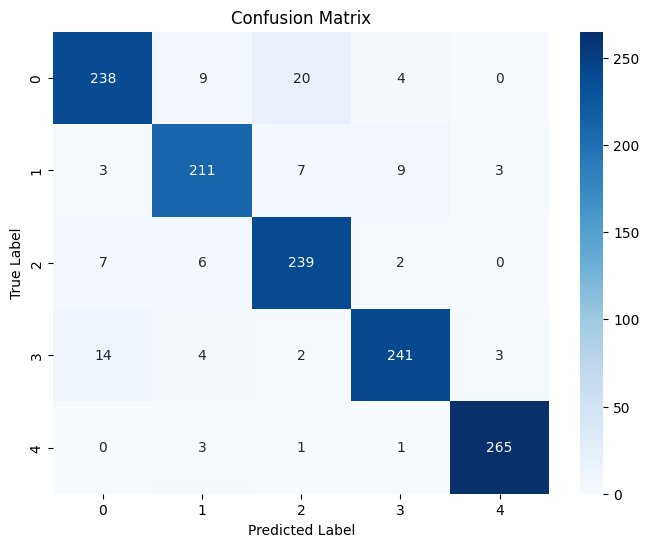

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       271
           1       0.91      0.91      0.91       233
           2       0.89      0.94      0.91       254
           3       0.94      0.91      0.93       264
           4       0.98      0.98      0.98       270

    accuracy                           0.92      1292
   macro avg       0.92      0.92      0.92      1292
weighted avg       0.92      0.92      0.92      1292



In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_distill = np.argmax(distiller.predict(X_test), axis=1)

# True labels
y_true = y_test

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_distill)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_distill))

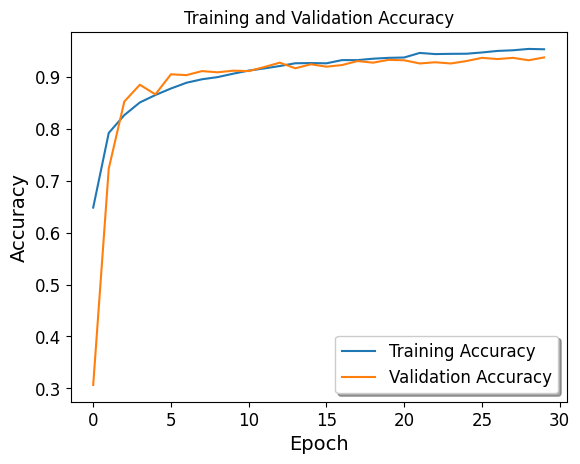

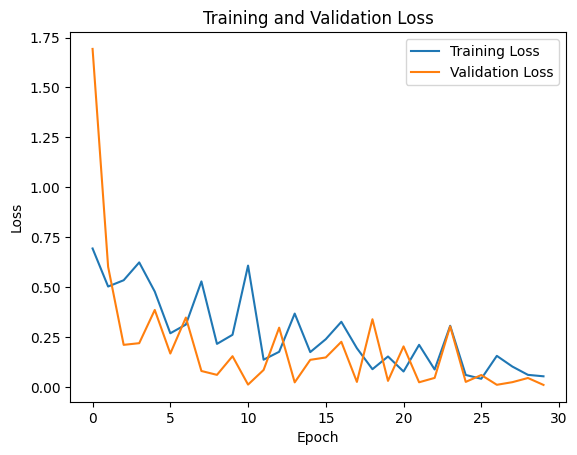

In [68]:
# Plotting training and validation accuracy
plt.plot(history_distill.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history_distill.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Training and Validation Accuracy')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(shadow=True, fontsize=12)

plt.show()

# Plotting training and validation loss
plt.plot(history_distill.history['student_loss'], label='Training Loss')
plt.plot(history_distill.history['val_student_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [45]:
training_loss = history_distill.history['student_loss']
validation_loss = history_distill.history['val_student_loss']

training_accuracy = history_distill.history['sparse_categorical_accuracy']
validation_accuracy = history_distill.history['val_sparse_categorical_accuracy']

In [46]:
# Convert them to numpy arrays
training_loss_array = np.array(training_loss)
validation_loss_array = np.array(validation_loss)

# Convert them to numpy arrays
training_loss_array = np.array(training_loss)
validation_loss_array = np.array(validation_loss)

# Save the arrays to .npy files
np.save('SGD_training_loss.npy', training_loss_array)
np.save('SGD_validation_loss.npy', validation_loss_array)
        
# Convert them to numpy arrays
training_accuracy_array = np.array(training_accuracy)
validation_accuracy_array = np.array(validation_accuracy)

# Save the arrays to .npy files
np.save('SGD_training_accuracy.npy', training_accuracy_array)
np.save('SGD_validation_accuracy.npy', validation_accuracy_array)

In [47]:
# Save the student model as a .keras file
distiller.student.save('Lidbox_student_model.keras')

In [49]:
training_loss_array

array([0.69351971, 0.5029394 , 0.53445441, 0.62370694, 0.47763222,
       0.26878995, 0.31228969, 0.5285207 , 0.21553609, 0.26106676,
       0.60782796, 0.13642552, 0.17596209, 0.36738956, 0.17450112,
       0.23920098, 0.32621577, 0.19390452, 0.08880259, 0.15246628,
       0.07718028, 0.21085808, 0.08729693, 0.30634177, 0.05990209,
       0.04086135, 0.15561423, 0.10198762, 0.06046765, 0.05320926])

In [50]:
validation_loss_array

array([1.69315577, 0.60169995, 0.21073572, 0.21912213, 0.38549337,
       0.1672554 , 0.34748778, 0.07981822, 0.06043383, 0.15392113,
       0.01162287, 0.08503133, 0.29680613, 0.02281257, 0.13567951,
       0.14765392, 0.22607546, 0.02509905, 0.33905292, 0.03027751,
       0.20304637, 0.02326699, 0.04522719, 0.30357233, 0.02517693,
       0.05960708, 0.01064911, 0.02383061, 0.04473523, 0.01003486])

## Combined Loss graph of 3 optimizers

In [51]:
# Data
rmsprop_train_loss = [
    1.0597676038742065, 0.606681764125824, 0.40444958209991455, 0.4264318645000458,
    1.0578287839889526, 0.28864192962646484, 0.22540558874607086, 0.18462681770324707,
    0.4478166103363037, 0.29647547006607056, 0.1516745686531067, 0.3012695610523224,
    0.18679463863372803, 0.07324157655239105, 0.09295052289962769, 0.20234006643295288,
    0.11739668250083923, 0.4094443619251251, 0.2039220929145813, 0.18758262693881989,
    0.2716447412967682, 0.1042565330862999, 0.15864188969135284, 0.24550513923168182,
    0.034629419445991516, 0.1354561299085617, 1.7789306640625, 0.507447361946106,
    0.06684557348489761, 0.0909341424703598, 0.06229760870337486, 0.0794779360294342,
    0.10671509802341461, 0.1670897901058197, 0.012470659799873829, 0.1097596138715744,
    0.0363767072558403, 0.11286908388137817, 0.23484593629837036, 0.014387853443622589,
    0.0007267538458108902, 0.0891701802611351, 0.21951840817928314, 0.2989163100719452,
    0.15514764189720154, 0.05914905294775963, 0.20297016203403473, 0.11245850473642349,
    0.13709142804145813, 0.7266772985458374, 0.09391577541828156, 0.39469674229621887,
    0.10044874250888824, 0.2469671368598938, 0.020655561238527298, 0.1125350371003151,
    0.06668020784854889, 0.10905840992927551, 0.3295215368270874, 0.005765095353126526
]

rmsprop_val_loss = [
    1.6535444259643555, 0.8383519649505615, 0.548332154750824, 1.2597324848175049,
    1.5486472845077515, 0.30119773745536804, 0.5075292587280273, 0.2442796677350998,
    0.37950149178504944, 1.2962340116500854, 0.2031681388616562, 0.35586056113243103,
    0.13716696202754974, 0.3837583065032959, 0.8847422003746033, 0.3142317831516266,
    0.14819443225860596, 0.6878657341003418, 0.09730976819992065, 0.15359798073768616,
    0.2567882239818573, 0.44848212599754333, 0.2218635529279709, 0.18014012277126312,
    0.4938909113407135, 0.5475282669067383, 0.4153224229812622, 1.0671457052230835,
    0.11598452180624008, 0.07897147536277771, 0.40598928928375244, 0.12588618695735931,
    0.1725120097398758, 0.1216646060347557, 0.3454004228115082, 0.37526002526283264,
    0.6326939463615417, 0.4949822425842285, 0.1643500179052353, 0.6831490993499756,
    0.39824533462524414, 0.7473049759864807, 0.49870553612709045, 0.38608813285827637,
    0.14683862030506134, 0.11686714738607407, 0.11629991978406906, 0.6434053778648376,
    0.1560860127210617, 0.27318647503852844, 0.10207978636026382, 0.2570006847381592,
    0.2686382234096527, 0.19065432250499725, 0.46586811542510986, 0.03123253583908081,
    0.0348140187561512, 1.2575603723526, 0.06376469880342484, 0.09411955624818802
]

adam_train_loss = [
    0.50480342, 0.43025219, 0.39001682, 0.58230424, 0.74249613, 0.34760207,
    0.37860864, 0.13312508, 0.21785736, 0.17299515, 0.08421101, 0.06193235,
    0.18350485, 0.07078823, 0.14466038, 0.19622612, 0.11807002, 0.25515884,
    0.41807836, 0.10919787, 0.13205349, 0.06977399, 0.26480803, 0.20210427,
    0.04572172, 0.10206697, 0.23211484, 0.19085309, 0.05851746, 0.23961133,
    0.16706036, 0.05690232, 0.15105689, 0.08776656, 0.05380953, 0.42442423,
    0.12046152, 0.00804649, 0.17283918, 0.06071052, 0.04555736, 0.1987596,
    0.14466697, 0.11074131, 0.03634141, 0.06795233, 0.02798049, 0.20915595,
    0.32172364, 0.04515409, 0.12793764, 0.15994665, 0.51573443, 0.19949897,
    0.09756278, 0.10402346, 0.08796377, 0.02941383, 0.00170612, 0.0250664
]

adam_val_loss = [
    0.83606029, 0.31173238, 0.29835048, 0.22466254, 0.32886341,
    0.45084253, 0.39831543, 0.1112864 , 0.57077891, 0.27866927,
    0.20608753, 0.07864946, 0.1569612 , 0.82332826, 0.37983629,
    0.61665148, 0.19521214, 0.65828055, 0.65317321, 0.13285582,
    0.15734789, 0.6426717 , 0.12913656, 0.63785452, 0.30458879,
    0.7405476 , 1.38631141, 0.76710248, 0.22228701, 1.22636533,
    1.14145517, 1.10731184, 0.96039397, 1.25181079, 0.67823887,
    0.18947308, 0.64946759, 0.20948978, 0.57551897, 1.59557819,
    0.11919958, 0.41308841, 0.72991562, 0.14159271, 0.42237377,
    2.58500266, 0.72371644, 0.85353273, 1.30689955, 0.1773427 ,
    0.08538494, 0.12415735, 0.1908087 , 2.27596831, 0.14805274,
    0.71135801, 2.10244012, 0.81082726, 1.219347  , 0.28727159
]

sgd_train_loss = [
       0.69351971, 0.5029394 , 0.53445441, 0.62370694, 0.47763222,
       0.26878995, 0.31228969, 0.5285207 , 0.21553609, 0.26106676,
       0.60782796, 0.13642552, 0.17596209, 0.36738956, 0.17450112,
       0.23920098, 0.32621577, 0.19390452, 0.08880259, 0.15246628,
       0.07718028, 0.21085808, 0.08729693, 0.30634177, 0.05990209,
       0.04086135, 0.15561423, 0.10198762, 0.06046765, 0.05320926
]

sgd_val_loss = [
       1.69315577, 0.60169995, 0.21073572, 0.21912213, 0.38549337,
       0.1672554 , 0.34748778, 0.07981822, 0.06043383, 0.15392113,
       0.01162287, 0.08503133, 0.29680613, 0.02281257, 0.13567951,
       0.14765392, 0.22607546, 0.02509905, 0.33905292, 0.03027751,
       0.20304637, 0.02326699, 0.04522719, 0.30357233, 0.02517693,
       0.05960708, 0.01064911, 0.02383061, 0.04473523, 0.01003486
]





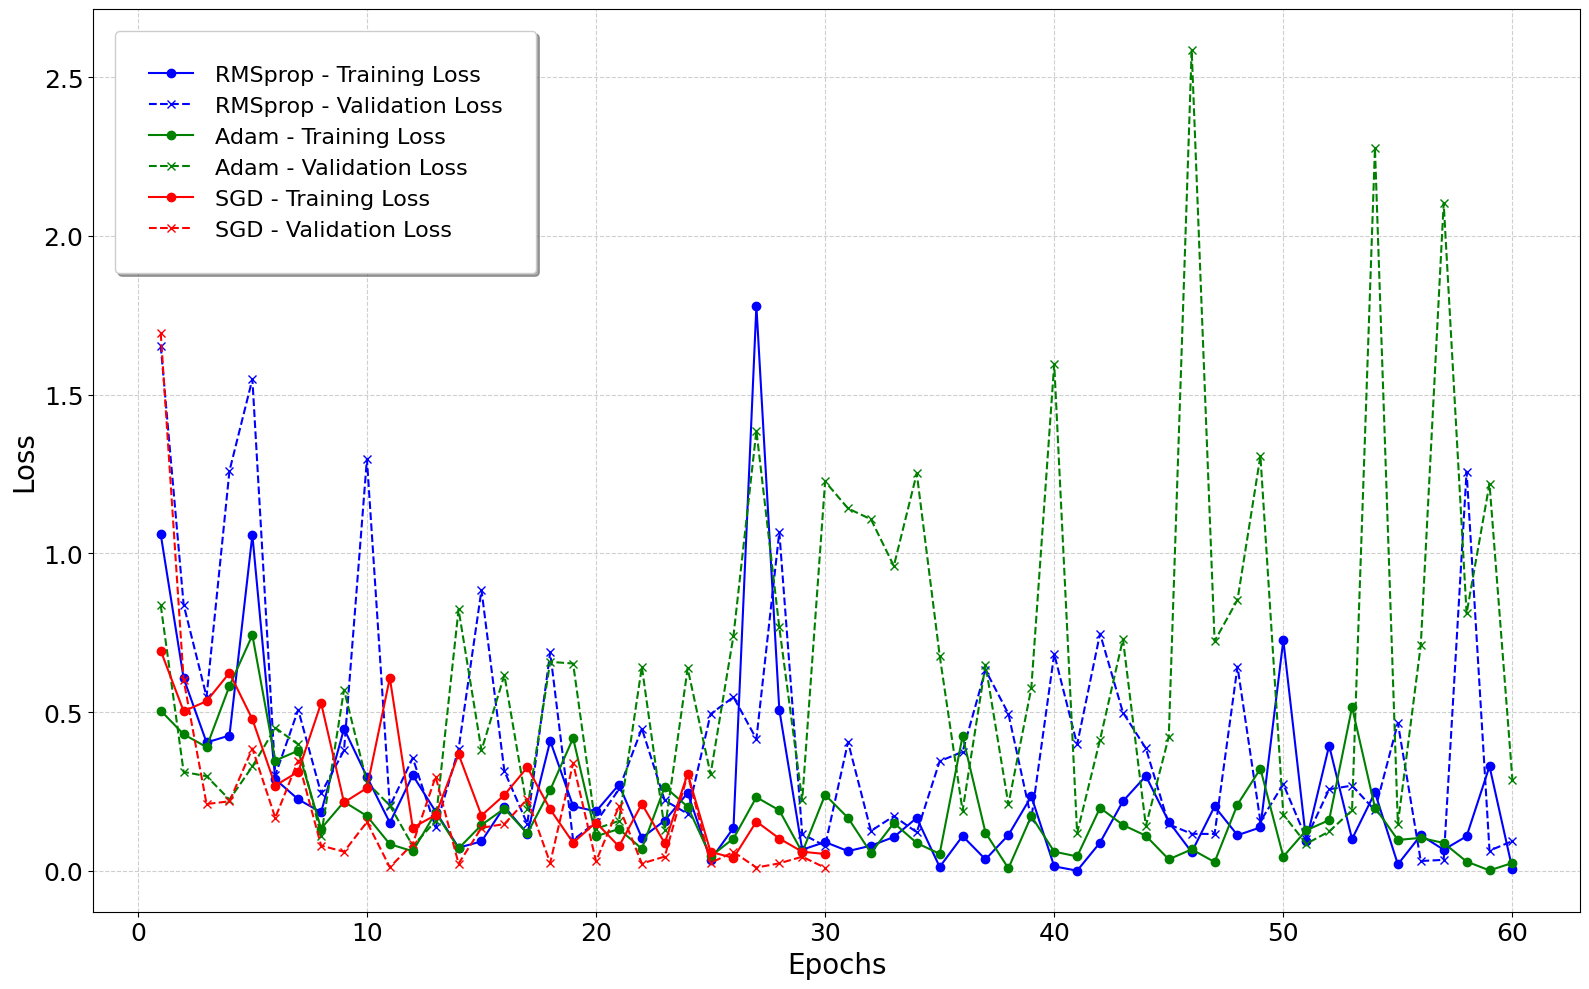

In [56]:
import matplotlib.pyplot as plt

# Assuming 'epochs' is defined with the correct length
epochs = range(1, len(rmsprop_train_loss) + 1)
epoch_sgd = range(1, len(sgd_train_loss) + 1)
plt.figure(figsize=(16, 10))  # Increase the size of the figure

# RMSprop
plt.plot(epochs, rmsprop_train_loss, label='RMSprop - Training Loss', linestyle='-', marker='o', color='blue')
plt.plot(epochs, rmsprop_val_loss, label='RMSprop - Validation Loss', linestyle='--', marker='x', color='blue')

# Adam
plt.plot(epochs, adam_train_loss, label='Adam - Training Loss', linestyle='-', marker='o', color='green')
plt.plot(epochs, adam_val_loss, label='Adam - Validation Loss', linestyle='--', marker='x', color='green')

# SGD
plt.plot(epoch_sgd, sgd_train_loss, label='SGD - Training Loss', linestyle='-', marker='o', color='red')
plt.plot(epoch_sgd, sgd_val_loss, label='SGD - Validation Loss', linestyle='--', marker='x', color='red')

# Labels and title with larger font size
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)


# Adding a legend with a larger font size and increased box size
plt.legend(loc='upper left', shadow=True, fontsize=16, borderpad=1.5, borderaxespad=1, handlelength=2, handletextpad=1)

# Increasing font size of tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

# Show the plot
plt.show()


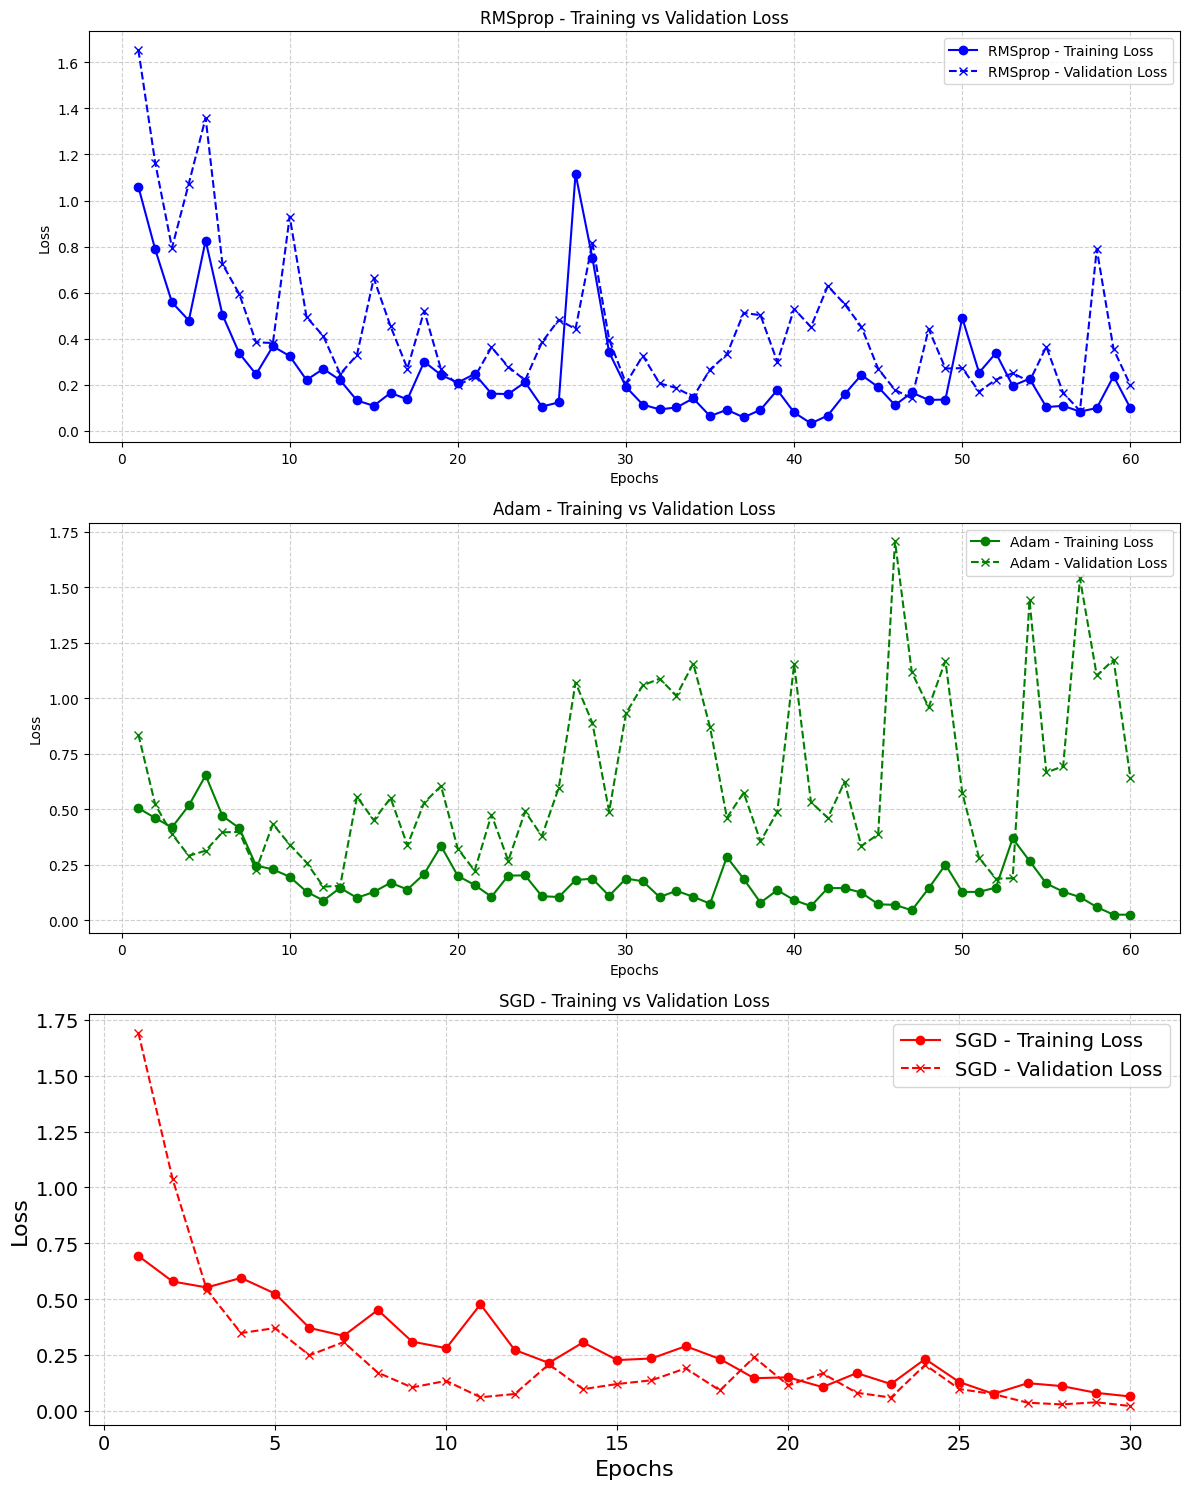

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Function to smooth the data using a moving average
def smooth_data(data, smoothing_factor=0.6):
    smoothed = []
    for i in range(len(data)):
        if i == 0:
            smoothed.append(data[i])
        else:
            smoothed.append(smoothing_factor * data[i] + (1 - smoothing_factor) * smoothed[i-1])
    return smoothed

# Smoothing the loss data
rmsprop_train_loss_smoothed = smooth_data(rmsprop_train_loss)
rmsprop_val_loss_smoothed = smooth_data(rmsprop_val_loss)
adam_train_loss_smoothed = smooth_data(adam_train_loss)
adam_val_loss_smoothed = smooth_data(adam_val_loss)
sgd_train_loss_smoothed = smooth_data(sgd_train_loss)
sgd_val_loss_smoothed = smooth_data(sgd_val_loss)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# RMSprop
axs[0].plot(epochs, rmsprop_train_loss_smoothed, label='RMSprop - Training Loss', linestyle='-', marker='o', color='blue')
axs[0].plot(epochs, rmsprop_val_loss_smoothed, label='RMSprop - Validation Loss', linestyle='--', marker='x', color='blue')
axs[0].set_title('RMSprop - Training vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.6)

# Adam
axs[1].plot(epochs, adam_train_loss_smoothed, label='Adam - Training Loss', linestyle='-', marker='o', color='green')
axs[1].plot(epochs, adam_val_loss_smoothed, label='Adam - Validation Loss', linestyle='--', marker='x', color='green')
axs[1].set_title('Adam - Training vs Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.6)

# SGD
axs[2].plot(epoch_sgd, sgd_train_loss_smoothed, label='SGD - Training Loss', linestyle='-', marker='o', color='red')
axs[2].plot(epoch_sgd, sgd_val_loss_smoothed, label='SGD - Validation Loss', linestyle='--', marker='x', color='red')
axs[2].set_title('SGD - Training vs Validation Loss')
axs[2].set_xlabel('Epochs',fontsize = 16)
axs[2].set_ylabel('Loss',fontsize = 16)
axs[2].legend(fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
axs[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


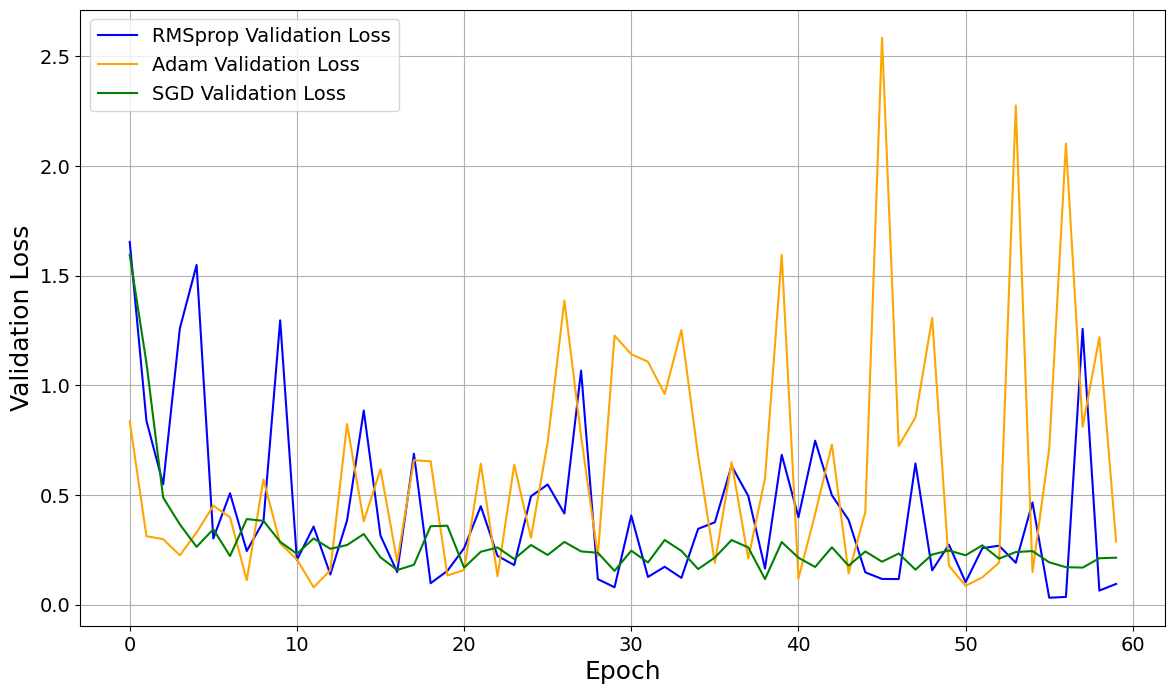

In [8]:
# Data
rmsprop_val_loss = [
    1.6535444259643555, 0.8383519649505615, 0.548332154750824, 1.2597324848175049,
    1.5486472845077515, 0.30119773745536804, 0.5075292587280273, 0.2442796677350998,
    0.37950149178504944, 1.2962340116500854, 0.2031681388616562, 0.35586056113243103,
    0.13716696202754974, 0.3837583065032959, 0.8847422003746033, 0.3142317831516266,
    0.14819443225860596, 0.6878657341003418, 0.09730976819992065, 0.15359798073768616,
    0.2567882239818573, 0.44848212599754333, 0.2218635529279709, 0.18014012277126312,
    0.4938909113407135, 0.5475282669067383, 0.4153224229812622, 1.0671457052230835,
    0.11598452180624008, 0.07897147536277771, 0.40598928928375244, 0.12588618695735931,
    0.1725120097398758, 0.1216646060347557, 0.3454004228115082, 0.37526002526283264,
    0.6326939463615417, 0.4949822425842285, 0.1643500179052353, 0.6831490993499756,
    0.39824533462524414, 0.7473049759864807, 0.49870553612709045, 0.38608813285827637,
    0.14683862030506134, 0.11686714738607407, 0.11629991978406906, 0.6434053778648376,
    0.1560860127210617, 0.27318647503852844, 0.10207978636026382, 0.2570006847381592,
    0.2686382234096527, 0.19065432250499725, 0.46586811542510986, 0.03123253583908081,
    0.0348140187561512, 1.2575603723526, 0.06376469880342484, 0.09411955624818802
]

adam_val_loss = [
    0.83606029, 0.31173238, 0.29835048, 0.22466254, 0.32886341,
    0.45084253, 0.39831543, 0.1112864 , 0.57077891, 0.27866927,
    0.20608753, 0.07864946, 0.1569612 , 0.82332826, 0.37983629,
    0.61665148, 0.19521214, 0.65828055, 0.65317321, 0.13285582,
    0.15734789, 0.6426717 , 0.12913656, 0.63785452, 0.30458879,
    0.7405476 , 1.38631141, 0.76710248, 0.22228701, 1.22636533,
    1.14145517, 1.10731184, 0.96039397, 1.25181079, 0.67823887,
    0.18947308, 0.64946759, 0.20948978, 0.57551897, 1.59557819,
    0.11919958, 0.41308841, 0.72991562, 0.14159271, 0.42237377,
    2.58500266, 0.72371644, 0.85353273, 1.30689955, 0.1773427 ,
    0.08538494, 0.12415735, 0.1908087 , 2.27596831, 0.14805274,
    0.71135801, 2.10244012, 0.81082726, 1.219347  , 0.28727159
]

sgd_val_loss = [
    1.59534264, 1.10224986, 0.48798358, 0.36545536, 0.26331493,
    0.3435767 , 0.2212922 , 0.38994846, 0.38171163, 0.28606719,
    0.23139443, 0.30143568, 0.25421599, 0.27154145, 0.32155958,
    0.21517532, 0.15750621, 0.18130778, 0.35742435, 0.35933113,
    0.16838257, 0.24088363, 0.26042029, 0.20765162, 0.27165127,
    0.22617649, 0.28568065, 0.24237309, 0.23633696, 0.15370999,
    0.24575818, 0.19199462, 0.29449955, 0.24470891, 0.1618083 ,
    0.21445507, 0.2942988 , 0.26048082, 0.11607978, 0.2850363 ,
    0.21377115, 0.17144395, 0.26119116, 0.17725269, 0.24240112,
    0.195315  , 0.23303711, 0.15917112, 0.22830568, 0.24630082,
    0.22489284, 0.27012947, 0.20959359, 0.23947455, 0.2439065 ,
    0.19274797, 0.17049335, 0.16862541, 0.21125752, 0.21381576
]


# Plotting
plt.figure(figsize=(14, 8))  # Increased size

plt.plot(rmsprop_val_loss, label='RMSprop Validation Loss', color='blue')
plt.plot(adam_val_loss, label='Adam Validation Loss', color='orange')
plt.plot(sgd_val_loss, label='SGD Validation Loss', color='green')

plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Validation Loss', fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.grid(True)

# Increase size of x-axis tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()



## Testing on short utterance

In [68]:
test_dir = 'LongShortUtteranceData/'

In [69]:
test_df = pd.read_csv("Total_short_Utterance_file.csv")
test_df.head()

,FileName,Label
0,common_voice_en_38487409.wav,English
1,common_voice_en_38487410.wav,English
2,common_voice_en_38487420.wav,English
3,common_voice_en_38487556.wav,English
4,common_voice_en_38491060.wav,English


In [70]:
mfccs_list_test = []
labels_test = []

In [71]:
for index, row in test_df.iterrows():
    file_path = os.path.join(test_dir, row['FileName'])
    mfccs = load_and_preprocess_old(file_path)
    mfccs_list_test.append(mfccs.T)
    labels_test.append(row['Label'])

In [72]:
print(len(mfccs_list_test))
print(len(labels_test))

2500
2500


In [73]:

padded_mfccs_test = pad_sequences(mfccs_list_test, dtype='float32', padding='post', truncating='post')

print(padded_mfccs_test.shape)

(2500, 188, 13)


In [74]:
mfccs_array_test = np.array(padded_mfccs_test)

In [75]:
# Flatten MFCCs array to 2D
mfccs_flattened_test = mfccs_array_test.reshape(-1, mfccs_array.shape[-1])

In [76]:
mfccs_scaled_test = scaler.fit_transform(mfccs_flattened_test)

In [77]:
# data back to 3D
mfccs_scaled_3d_test = mfccs_scaled_test.reshape(mfccs_array_test.shape[0], mfccs_array_test.shape[1], mfccs_array_test.shape[2])

In [78]:
X_test_short = np.array(mfccs_scaled_3d_test)
y_test_short = np.array(labels_test)

In [79]:
X_test_short.shape

(2500, 188, 13)

In [80]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_test_short)

In [81]:
#saving the testing arays 

np.save('1D_CNN_X_test_short.npy', X_test_short)
np.save('1D_CNN_y_test_short.npy', y_encoded)

In [82]:
evaluation_result = teacher.evaluate(X_test_short, y_encoded)

79/79 [==============================] - 1s 12ms/step - loss: 6.0623 - sparse_categorical_accuracy: 0.7292


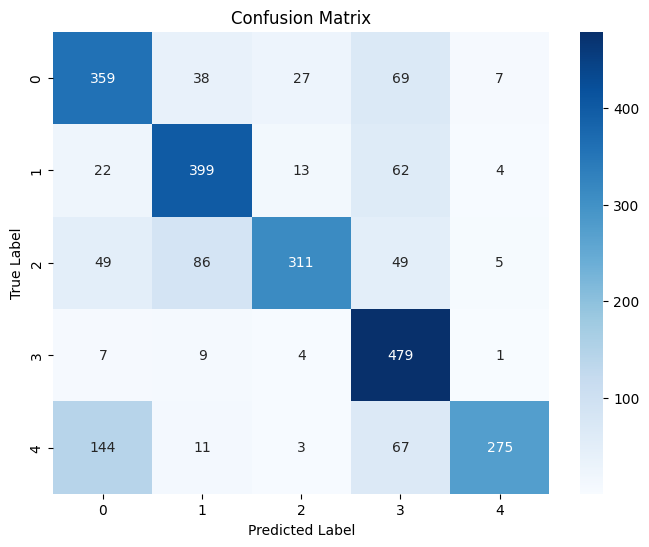

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.72      0.66       500
           1       0.73      0.80      0.77       500
           2       0.87      0.62      0.72       500
           3       0.66      0.96      0.78       500
           4       0.94      0.55      0.69       500

    accuracy                           0.73      2500
   macro avg       0.76      0.73      0.73      2500
weighted avg       0.76      0.73      0.73      2500



In [83]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_teacher = np.argmax(teacher.predict(X_test_short), axis=1)

# True labels
y_true = y_encoded

# Create confusion matrix
cm = confusion_matrix(y_encoded, y_pred_teacher)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_teacher))

In [84]:
evaluation_result = distiller.evaluate(X_test_short, y_encoded)

79/79 [==============================] - 1s 8ms/step - sparse_categorical_accuracy: 0.7344 - student_loss: 1.6224


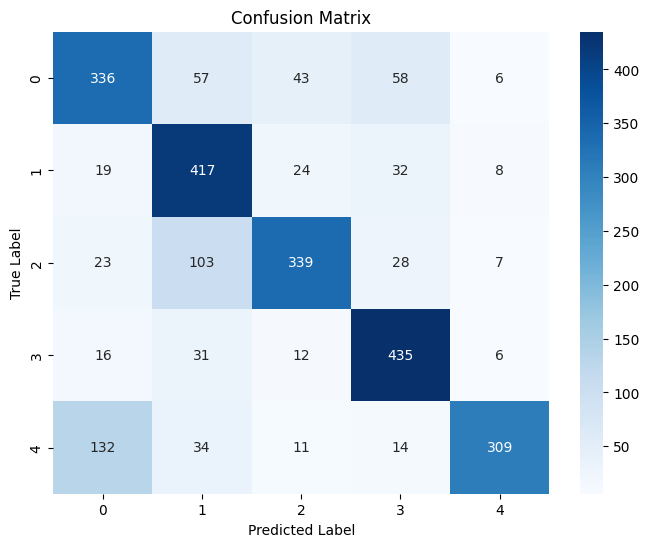

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65       500
           1       0.65      0.83      0.73       500
           2       0.79      0.68      0.73       500
           3       0.77      0.87      0.82       500
           4       0.92      0.62      0.74       500

    accuracy                           0.73      2500
   macro avg       0.75      0.73      0.73      2500
weighted avg       0.75      0.73      0.73      2500



In [85]:

y_pred_student = np.argmax(distiller.predict(X_test_short), axis=1)

# True labels
y_true = y_encoded

# Create confusion matrix
cm = confusion_matrix(y_encoded, y_pred_student)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_student))

In [2]:
X_test_short_loaded = np.load('1D_CNN_X_test_short.npy')
y_test_short_loaded = np.load('1D_CNN_y_test_short.npy')

In [3]:
X_test_short_loaded.shape

(2500, 188, 13)